In [1]:
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

# numpy
import numpy as np

from h5 import HDFArchive

In this basic example we will perform a VASP calculation for SrVO$_3$, build PLOs for the Vanadium t$_{2g}$ orbitals, and load them as SumK object, which can be then used to perform a DMFT calculation. 

__Note: This example works with VASP version 6.5.0 or newer with hdf5 support enabled__

## VASP setup

First we setup the VASP [INCAR link](INCAR) file by specifing the LOCPROJ, EMIN, EMAX and LORBIT flags:

```
SYSTEM = SrVO3
NCORE = 4
LMAXMIX=6
EDIFF = 1.E-10

# DOS energy window
NEDOS = 2001

# Smearing procedure
ISMEAR = -5

# the energy window to optimize projector channels
EMIN = 3.9
EMAX = 7.1

# use the PAW channel optimization
LORBIT=14

# project to V d
LOCPROJ = 2 : d : Pr
```
Moreover we prepare a [KPOINTS link](KPOINTS), [POSCAR link](POSCAR), and a POTCAR file. For the POTCAR file please use the VASP provided PBE pseudopotentials: `Sr_sv`, `V`, and `O`. 

Now VASP is executed, which should converge in roughly 27 iterations. Afterwards you should find the files LOCPROJ and PROJCAR in you directory. 

## PLOVASP

First import the PLOVASP module of DFTTools:

In [2]:
# import plovasp converter
import triqs_dft_tools.converters.plovasp.converter as plo_converter

Starting serial run at: 2025-02-21 14:05:20.237950


Next, create a configuration file for plovasp [plo.cfg link](plo.cfg):

```
[General]
DOSMESH = -3.0 3.0 2001

[Shell 1]
LSHELL = 2
IONS = 2
EWINDOW = -1.4 2.0

TRANSFORM = 1.0  0.0  0.0  0.0  0.0
            0.0  1.0  0.0  0.0  0.0
            0.0  0.0  0.0  1.0  0.0

```
where the energy window of the t$_{2g}$ bands is specified by `EWINDOW` and the `TRANSFORM` flag picks the correct three orbitals out of the five Vanadium $d$ orbitals [see the guide for the ordering of orbitals](../../guide/conv_vasp.html). 

Now run PLOVASP:

In [3]:
# Generate and store PLOs
plo_converter.generate_and_output_as_text('plo.cfg', vasp_dir='./')

[WARNING]: Reading from vaspout.h5
Read parameters: LOCPROJ
0  ->  {'label': 'dxy       ', 'isite': 2, 'coord': array([-0.5, -0.5, -0.5]), 'l': 2, 'm': 0}
1  ->  {'label': 'dyz       ', 'isite': 2, 'coord': array([-0.5, -0.5, -0.5]), 'l': 2, 'm': 1}
2  ->  {'label': 'dz2       ', 'isite': 2, 'coord': array([-0.5, -0.5, -0.5]), 'l': 2, 'm': 2}
3  ->  {'label': 'dxz       ', 'isite': 2, 'coord': array([-0.5, -0.5, -0.5]), 'l': 2, 'm': 3}
4  ->  {'label': 'dx2-y2    ', 'isite': 2, 'coord': array([-0.5, -0.5, -0.5]), 'l': 2, 'm': 4}
  Total number of ions: 5
  Number of types: 3
  Number of ions for each type: [1 1 3]

   Reduced number of k-points: 120
    Total number of k-points: 3375
   Total number of tetrahedra: 1667
eigvals from EIGENVAL

  Unorthonormalized density matrices and overlaps:
  Spin: 1
  Site: 2
  Density matrix                                                  Overlap
   0.6117996  -0.0000018  -0.0000000  -0.0000018  -0.0000007       0.9363450   0.0000000   0.0000000  -

PLOVASP created one shell with three orbitals, which are equally filled by 1/3, one electron in total. Additionally we calculated the density of states. Both in VASP and PLOVASP. The later stores the data in the file pdos_x.dat, which can be simply plotted with [matplotlib](https://matplotlib.org/):

In [4]:
plo_dos = np.loadtxt('pdos_0_0.dat')

with HDFArchive('vaspout.h5','r') as vaspout:
    vasp_dos = vaspout['results/electron_dos/dos']
    vasp_dos_energies = vaspout['results/electron_dos/energies']
    vasp_fermi = vaspout['results/electron_dos/efermi']

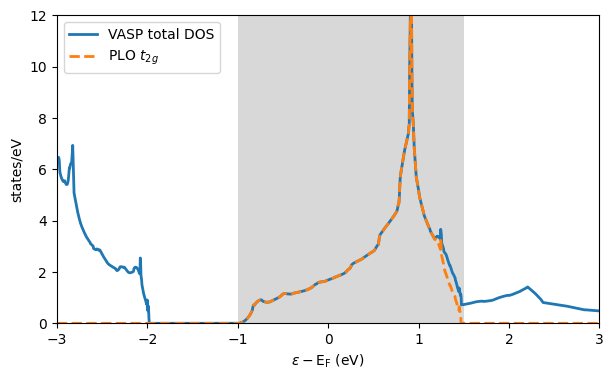

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(7,4))

plt.plot(vasp_dos_energies-vasp_fermi, vasp_dos[0,:], lw=2, label=r'VASP total DOS')

plt.plot(plo_dos[:,0],plo_dos[:,1]+plo_dos[:,2]+plo_dos[:,3], '--', lw=2, label=r'PLO $t_{2g}$')

plt.axvspan(-1., 1.5, facecolor='gray', alpha=0.3)

plt.xlim([-3,3])
plt.ylim(0,12)
plt.xlabel(r'$\epsilon - {\text{E}_\text{F}}$ (eV)')
plt.ylabel(r'states/eV')
plt.legend()

plt.show()

Here the gray area highlights the energy window for the PLOs. The total DOS of VASP (blue) coincides with the PLO DOS in the window, as we re-orthonormalized the projector functions in the given window, picking up also Oxygen weight. This setting is closest to the result of maximally localized Wannier functions created with [wannier90](http://www.wannier.org/) without running the actual minimization of the spread. Note, for a proper comparison one can use the hydrogen projector in VASP by using the the line `LOCPROJ=  2 : d : Hy`, instead of `Pr`. 


## Converting to hdf5 file

Finally we can run the VASP converter to create a h5 file:

In [6]:
# import VASPconverter
from triqs_dft_tools.converters.vasp import *


# create Converter
Converter = VaspConverter(filename = 'vasp')
# run the converter
Converter.convert_dft_input()

Reading input from vasp.ctrl...
{
    "ngroups": 1,
    "nk": 3375,
    "nkibz": 120,
    "ns": 1,
    "kvec1": [
        0.2602750065719439,
        0.0,
        0.0
    ],
    "kvec2": [
        0.0,
        0.2602750065719439,
        0.0
    ],
    "kvec3": [
        0.0,
        0.0,
        0.2602750065719439
    ],
    "nc_flag": 0
}

  No. of inequivalent shells: 1


The resulting h5 file `vasp.h5` can now be loaded as sumk object via:

In [7]:
# SumK
from triqs_dft_tools.sumk_dft_tools import SumkDFTTools

SK = SumkDFTTools(hdf_file='vasp.h5', use_dft_blocks = False)

Here one should carefully determine the block structure manually. This is important to find degenerate orbitals and spin-channels:

In [8]:
G = SK.extract_G_loc(transform_to_solver_blocks=False)
SK.analyse_block_structure_from_gf(G, threshold = 1e-3)
for i_sh in range(len(SK.deg_shells)):
    num_block_deg_orbs = len(SK.deg_shells[i_sh])
    mpi.report('found {0:d} blocks of degenerate orbitals in shell {1:d}'.format(num_block_deg_orbs, i_sh))
    for iblock in range(num_block_deg_orbs):
        mpi.report('block {0:d} consists of orbitals:'.format(iblock))
        for keys in list(SK.deg_shells[i_sh][iblock].keys()):
            mpi.report('  '+keys)

found 1 blocks of degenerate orbitals in shell 0
block 0 consists of orbitals:
  up_0
  up_1
  up_2
  down_0
  down_1
  down_2


This minimal example extracts the block structure by calculating once the local Green's functions and then finds degenerate orbitals with a certain threshold in `Gloc`. Afterwards the result is reported, where 1 block is found with size 6 (3x2 orbitals for spin), where a all 6 orbitals are marked as degenerate. This is indeed correct in cubic SrVO$_3$, as all 3 t$_{2g}$ orbitals are degenerate. Note: for a magnetic calculation one has to break the symmetry between up and down at this point manually. Moreover, one can reduce the threshold for example to `1e-5` and finds that then the degeneracy of the 3 t$_{2g}$ orbitals is not found anymore, resulting in only two degenerate blocks for spin up and down, each with size 3x3.

Afterwards the exact same DMFT script as in the [Wien2k tutorial](../srvo3.html) can be used. For a more elaborate example including charge self-consistency take a look at the [VASP NiO example](../nio_csc.html).